Epoch 0, Loss: 0.2553
Epoch 5, Loss: 0.0822
Epoch 10, Loss: 0.0480
Epoch 15, Loss: 0.0509
Epoch 20, Loss: 0.0361
Epoch 25, Loss: 0.0370
Epoch 30, Loss: 0.0314
Epoch 35, Loss: 0.0258
Epoch 40, Loss: 0.0225
Epoch 45, Loss: 0.0162
Epoch 50, Loss: 0.0110
Epoch 55, Loss: 0.0046

Metrics:
Close >> RMSE: $ 6.4742 R2:  0.9673 MAE: $ 5.0117


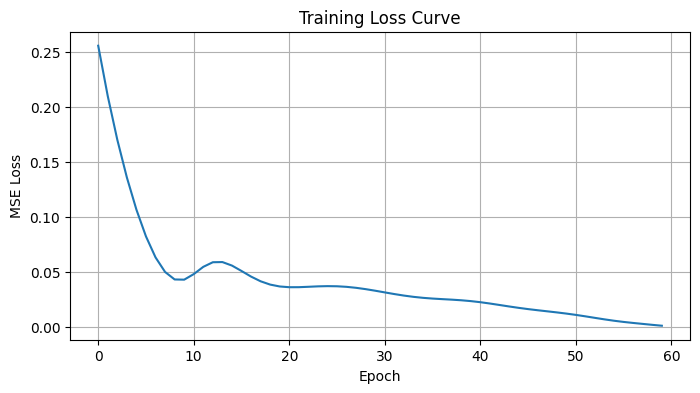

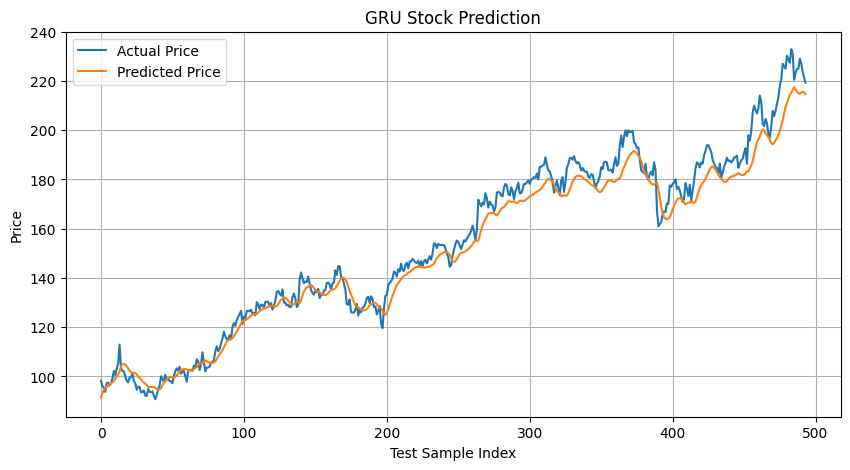

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("AMZN_processed.csv")
prices = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 50
X, y = create_sequences(prices_scaled, SEQ_LEN)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


class GRUNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

model = GRUNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

###############################
EPOCHS = 60
losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()
pred_test = model(X_test).detach().numpy()

pred_test = scaler.inverse_transform(pred_test)
actual_test = scaler.inverse_transform(y_test.numpy())

mse1 = mean_squared_error(actual_test, pred_test)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(actual_test, pred_test)
mae1 = mean_absolute_error(actual_test, pred_test)
print(f"\nMetrics:")
print("Close >> RMSE: $", "%.4f" %rmse1, "R2: ", "%.4f" %r2_1, "MAE: $", "%.4f" %mae1)


plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(actual_test, label="Actual Price")
plt.plot(pred_test, label="Predicted Price")
plt.title("GRU Stock Prediction")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
full_pred = np.zeros_like(prices)
full_pred[:] = np.nan  # fill with NaN so only predicted region shows

# Insert predictions into correct position (only for test region)
full_pred[train_size + SEQ_LEN:] = pred_test.reshape(-1)

plt.figure(figsize=(12,6))
plt.plot(prices, label="Actual Price")
plt.plot(full_pred, label="Predicted Price (Test Region)")
plt.title("Full Price Chart with Predicted Test Prices")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

ValueError: could not broadcast input array from shape (494,) into shape (494,1)